In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import fastai
import fastai.vision
import numpy as np

In [4]:
class ArrayImageList(fastai.vision.ImageList):
    @classmethod
    def from_numpy(cls, numpy_array):
        return cls(items=range(len(numpy_array)),inner_df=numpy_array)
    
    def label_from_array(self, array, label_cls=None, **kwargs):
        return self._label_from_list(array[self.items.astype(np.int)],
                                     label_cls=label_cls,
                                     **kwargs)
    
    def get(self, i):
        n = self.inner_df[i]
        n = fastai.vision.torch.tensor(n).float()
        return fastai.vision.Image(n)

In [6]:
learn = fastai.vision.load_learner('','NIR_model05.pkl')

In [7]:
import scipy.io as sio

def get_xY(filename, maxx=600):
    
    sio.whosmat(filename)

    matcontents = sio.loadmat(filename)
    keys = matcontents.keys()
#    for key in list(keys):
#        if key[0] == '_':
#            keys.remove(key)
#            print('_', key)
            
            
    d = {}            
    for key in keys:
        if key[0] != '_':
            data = matcontents[key][0][0]
            if key[-1] == "Y":
                Ydata = data[5]
                d[key] = Ydata
            else:
                xdata = data[5][:,:maxx]
                d[key] = xdata
                d["axisscale"]= data[7][1][0][0][:maxx].astype(np.float)
                    
    return d

In [8]:
filename = 'Dataset/nir_shootout_2002.mat'
dataset = get_xY(filename)
#Rescale to NN friendly number range
from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

#Calibrate is smaller than test, so they are swapped
X_train = xscaler.fit_transform(dataset['test_1']) #From instrument 1
X_test = xscaler.transform(dataset['calibrate_2']) #! NB only transform on test set. From instrument 2

yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform(dataset['test_Y'][:,2])
y_test = yscaler.transform(dataset['calibrate_Y'][:,2])

X_indepTest0 = np.asarray(xscaler.transform(dataset['test_2']), dtype=np.float32)
X_indepTest = X_indepTest0[:, np.newaxis, :] #Added dim to fit fastai.vision image structure
y_indepTest = y_train


In [9]:
ypred_indep = learn.predict(X_indepTest[0,:,:])
ypred_indep

(FloatItem [0.489441], tensor([0.4894]), tensor([0.4894]))

In [10]:
print('X_indepTest.shape', X_indepTest.shape)

X_indepTest.shape (460, 1, 600)


In [11]:
n_indep = X_indepTest.shape[0]
prd_indep = np.zeros((n_indep))
for prd in range(n_indep):
    ypred_indep = learn.predict(X_indepTest[prd,:,:])
    prd_indep[prd] = float(ypred_indep[1])

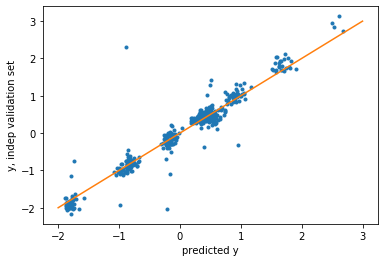

In [12]:
plt.plot(prd_indep, y_indepTest, '.')
plt.plot([-2,3], [-2,3])
plt.ylabel('y, indep validation set')
_  =plt.xlabel('predicted y')